## Resnet Retrained Model. All categories except Other (O)

We eliminate the images from Other diseases/abnormalities (O) class since each image has a different problem and we would be generalizing particularities which does not make sense and harms the model.

In this notebook we test using the weights obtained in the model from the 07_Resnet_7_classes.ipynb notebook and re-training the model for more epochs to see if a higher accuracy is achieved and the model learns.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
train_dir = './labeled-images-mod/train'
test_dir = './labeled-images-mod/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 500

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 4493 files belonging to 7 classes.
Using 3595 files for training.
Found 4493 files belonging to 7 classes.
Using 898 files for validation.
Found 569 files belonging to 7 classes.


### 02. Model architecture

Loading of pretrained Resnet50 model with imagenet and creation of the architecture.

In [ ]:
pretrained = ResNet50(weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 256)               42467584  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
 activation (Activation)     (None, 7)                 0

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./labeled-images-mod/train/')
cat_list.sort()

lenghts = [len(os.listdir('./labeled-images-mod/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['A', 'C', 'D', 'G', 'H', 'M', 'N']
[239, 264, 1447, 256, 115, 209, 1963]
[4.33589667773576, 4.125530268947253, 1.7635192088548397, 4.189272013130682, 6.250599971202765, 4.636809247747852, 1.5132745950421556]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs was set at 500 in order to appreciate the evolution of the model during training.

In [ ]:
patience = 50

early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze resnet
pretrained.trainable = False

model.compile(loss='categorical_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
model = load_model('resnet50mod-500epoch-freeze.h5')

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=1,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=1,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/500
1/1 [==============================] - 100s 100s/step - loss: 60.3562 - accuracy: 0.3125 - val_loss: 103.3175 - val_accuracy: 0.5312
Epoch 2/500
1/1 [==============================] - 18s 18s/step - loss: 89.0439 - accuracy: 0.5625 - val_loss: 95.3075 - val_accuracy: 0.5312
Epoch 3/500
1/1 [==============================] - 17s 17s/step - loss: 102.5879 - accuracy: 0.4375 - val_loss: 44.5762 - val_accuracy: 0.5000
Epoch 4/500
1/1 [==============================] - 17s 17s/step - loss: 75.3169 - accuracy: 0.3750 - val_loss: 88.8242 - val_accuracy: 0.2500
Epoch 5/500
1/1 [==============================] - 16s 16s/step - loss: 58.1956 - accuracy: 0.3438 - val_loss: 65.4025 - val_accuracy: 0.3125
Epoch 6/500
1/1 [==============================] - 15s 15s/step - loss: 60.3345 - accuracy: 0.3125 - val_loss: 81.5275 - val_accuracy: 0.0000e+00
Epoch 7/500
1/1 [==============================] - 15s 15s/step - loss: 86.2420 - accuracy: 0.0000e+00 - val_loss: 30.6724 - val_accuracy: 0

In [ ]:
model.save('resnet50mod-retrain1-freeze.h5')

### 05. Analysis of results

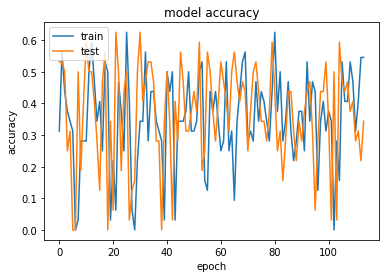

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the accuracy does not vary throughout the training and the value it takes is very low.

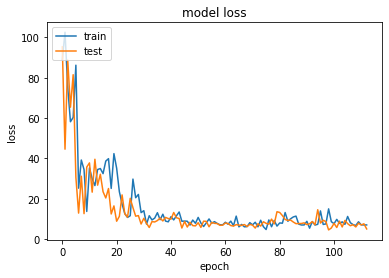

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases, which is the objective.

In [ ]:
model = load_model('resnet50mod-retrain1-freeze.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
y_real_class = y_real.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

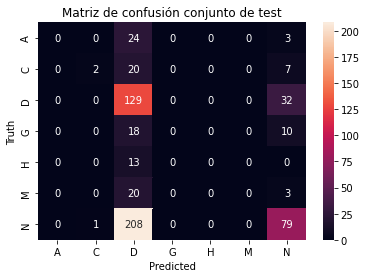

In [ ]:
labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N']

cf_matrix = confusion_matrix(y_real_class, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In this case, the model classifies all images within the class diabetes or normal.

In [ ]:
print(classification_report(y_real_class, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           C       0.67      0.07      0.12        29
           D       0.30      0.80      0.44       161
           G       0.00      0.00      0.00        28
           H       0.00      0.00      0.00        13
           M       0.00      0.00      0.00        23
           N       0.59      0.27      0.37       288

    accuracy                           0.37       569
   macro avg       0.22      0.16      0.13       569
weighted avg       0.42      0.37      0.32       569



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
